# Visualisation of the flows

In [1]:
# load libraries
import os
import pandas as pd
import pickle
import json
import osmnx as ox

# plotting
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.lines import Line2D

# loading H3
from pyproj import Transformer
from h3 import latlng_to_cell

# load helper functions
from spatial_interaction_tools import *

## Data Preparation

Load the network, do the analysis for H3 Grid (again), and merge back together.

In [2]:
# load network from pickle
with open('data/tokyo/drive_network_with_flow_multi.pkl', 'rb') as f:
    tokyo_drive_network = pickle.load(f)

with open('data/tokyo/multimodal_network_with_flow_multi.pkl', 'rb') as f:
    tokyo_multimodal_network = pickle.load(f)

In [3]:
# load the files

# with open('data/tokyo/remove_edges.json', 'r') as f:
#     removed_edges = json.load(f)
    
with open('data/tokyo/remove_nodes.json', 'r') as f:
    removed_nodes = json.load(f)

### Merge with H3 Grid

Load the data for H3 grids and POI density

In [4]:
# load h3 data
with open('data/tokyo/h3_poi_density.json', 'r') as f:
    poi_h3_dict = json.load(f)

In [5]:
# add this information to the driving network
# set crs for Tokyo
crs = 'EPSG:6677'

# reproject
transformer = Transformer.from_crs(crs, 'EPSG:4326', always_xy = True)

for n, d in tokyo_drive_network.nodes(data = True):
    
    # get h3 cell
    x, y = transformer.transform(d['x'], d['y'])
    h3_index = latlng_to_cell(y, x, 9)

    # add to node attribute
    d['h3_res09'] = h3_index
    d['poi_h3'] = poi_h3_dict[h3_index]

In [6]:
[n for n in tokyo_drive_network.edges(data = True)][:5]

[(31236562,
  7658031749,
  {'osmid': 316305908,
   'bridge': 'yes',
   'oneway': True,
   'lanes': '2',
   'ref': '11',
   'name': '首都高速11号台場線・東京港連絡橋',
   'highway': 'motorway',
   'reversed': False,
   'length': 41.081,
   'speed_kph': 60.6,
   'geometry': <LINESTRING (-6714.703 -40172.278, -6698.814 -40179.401, -6676.786 -40188.226)>,
   'travel_time': 2.4,
   'travel_time_mins': '0.04',
   'speed_kph_calib': '28.83848378687951',
   'travel_time_calib': '5.043260979835911',
   'travel_time_mins_calib': '0.08405434966393185',
   'flows_orig': 0,
   'flows_removed_Ginza': 0,
   'flows_removed_Akihabara': 0,
   'flows_removed_Shinjuku': 0,
   'flows_removed_Chuo_dori': 0,
   'flows_removed_all': 0,
   'flows_removed_Ginza_nodes': 0,
   'flows_removed_Akihabara_nodes': 0,
   'flows_removed_Shinjuku_nodes': 0,
   'flows_removed_Chuo_dori_nodes': 0,
   'flows_removed_all_nodes': 0,
   'flows_0': 0,
   'flows_10': 0,
   'flows_20': 0,
   'flows_30': 0,
   'flows_40': 0,
   'flows_50': 0,
 

In [7]:
[n for n in tokyo_drive_network.nodes(data = True)][10]

(31236747,
 {'y': -39876.438219753676,
  'x': -6992.849277238416,
  'street_count': 4,
  'highway': 'traffic_signals',
  'lon': 139.7561172,
  'lat': 35.6405486,
  'h3_res09': '892f5aadc83ffff',
  'poi_h3': 5.0})

In [8]:
# get the maximum flow for everything
max_flow = max([v for n in tokyo_drive_network.edges(data = True) for k,v in n[2].items() if 'flow' in k])

## Plot the Graph

In [21]:
# settings
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Garamond', 'DejaVu Serif', 'Bitstream Vera Serif', 'Computer Modern Roman', 'New Century Schoolbook', 'Century Schoolbook L', 'Utopia', 'ITC Bookman', 'Bookman', 'Nimbus Roman No9 L', 'Times New Roman', 'Times', 'Palatino', 'Charter', 'serif']

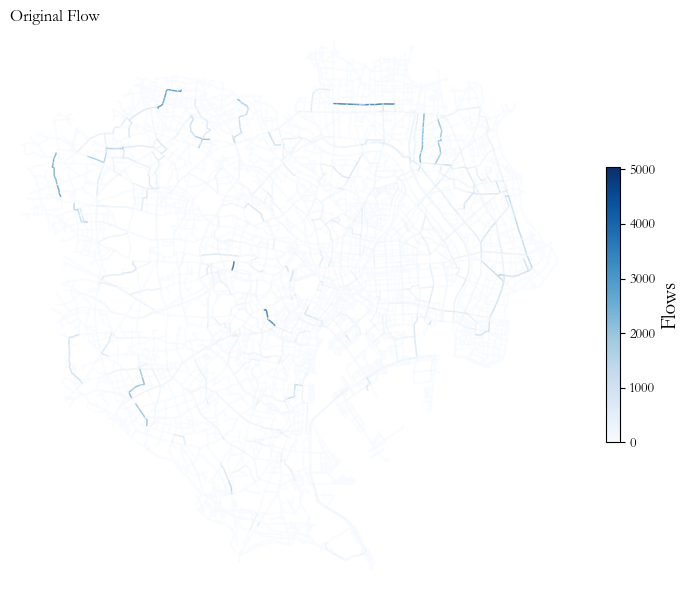

In [77]:
# Manually normalize the attribute values
edge_flows = ox.convert.graph_to_gdfs(tokyo_drive_network, nodes=False)[f'flows_orig']
normalized_flows = edge_flows / max_flow

# Get colors using the normalized values
cmap = plt.get_cmap('Blues')
colors_orig = [cmap(norm) if norm <= 1 else cmap(1.0) for norm in normalized_flows]

fig, ax = plt.subplots(1, 1, figsize = (8, 6))

# draw the drive network 
ox.plot_graph(
    tokyo_drive_network,
    edge_color = colors_orig,
    node_size = 0,
    edge_alpha = 0.5,
    bgcolor = 'white',
    ax = ax,
    show = False
)

# Add colorbar for the first plot
sm = cm.ScalarMappable(cmap = 'Blues', norm = mcolors.Normalize(vmin = 0, vmax = max_flow))
cbar = fig.colorbar(sm, ax = ax, aspect = 20, shrink = 0.5, fraction = 0.1)
cbar.set_label('Flows', fontsize = 15)

plt.title('Original Flow', loc = 'left', fontsize = 12)

plt.tight_layout()

plt.savefig('documents/img/flows_orig.png', bbox_inches = 'tight')

### Plot the Removed Scenarios

Plot them.

#### Edge removal

In [87]:
# iterate over scenarios
for scenario in removed_nodes:

    # create subgraph
    subgraph_temp = tokyo_drive_network.subgraph(removed_nodes[scenario]).copy()
    remove_edges = []
    for u,v,k,d in subgraph_temp.edges(data = True, keys = True):
        if d['highway'] == 'motorway':
            remove_edges.append((u,v,k))
    subgraph_temp.remove_edges_from(remove_edges)

    # Manually normalize the attribute values
    edge_flows = ox.convert.graph_to_gdfs(tokyo_drive_network, nodes=False)[f'flows_removed_{scenario}']
    normalized_flows = edge_flows / max_flow

    # Get colors using the normalized values
    cmap = plt.get_cmap('Blues')
    colors_poi = [cmap(norm) if norm <= 1 else cmap(1.0) for norm in normalized_flows]

    fig, ax = plt.subplots(1, 1, figsize = (8, 6))

    # draw the drive network 
    ox.plot_graph(
        tokyo_drive_network,
        edge_color = colors_poi,
        node_size = 0,
        edge_alpha = 0.7,
        bgcolor = 'white',
        ax = ax,
        show = False
    )

    # Add colorbar for the first plot
    sm = cm.ScalarMappable(cmap = 'Blues', norm = mcolors.Normalize(vmin = 0, vmax = max_flow))
    cbar = fig.colorbar(sm, ax = ax, aspect = 20, shrink = 0.5, fraction = 0.1)
    cbar.set_label('Flows', fontsize = 15)

    # Capture the bounding box of the first graph
    bbox = ax.get_xlim(), ax.get_ylim()

    # draw the removed edges
    ox.plot_graph(
        subgraph_temp,
        edge_color = 'lightcoral',
        edge_alpha = 0.7,
        node_size = 0,
        ax = ax,
        bgcolor = 'None',
        show = False
    )

    # Set the captured bounding box to the second plot
    ax.set_xlim(bbox[0])
    ax.set_ylim(bbox[1])

    # Add a legend to the second plot
    legend_handles = [
        Line2D([0], [0], color='lightcoral', lw=2, label='Removed edges')
    ]
    ax.legend(handles=legend_handles, loc='lower right', fontsize = 12)

    plt.title(f'Scenario: Removed {scenario} (Edge Removal)', loc = 'left', fontsize = 12)

    plt.tight_layout()
    plt.savefig(f'documents/img/flows_{scenario}.png', bbox_inches = 'tight')
    plt.close()

#### Node Removal


In [23]:
# iterate over scenarios
for scenario in removed_nodes:

    # create subgraph
    subgraph_edges = [(u,v,k) for u,v,k in tokyo_drive_network.edges(keys = True) if (u in removed_nodes[scenario]) or (v in removed_nodes[scenario])]

    subgraph_temp = tokyo_drive_network.edge_subgraph(subgraph_edges).copy()
    remove_edges = []
    for u,v,k,d in subgraph_temp.edges(data = True, keys = True):
        if d['highway'] == 'motorway':
            remove_edges.append((u,v,k))
    subgraph_temp.remove_edges_from(remove_edges)

    # Manually normalize the attribute values
    edge_flows = ox.convert.graph_to_gdfs(tokyo_drive_network, nodes=False)[f'flows_removed_{scenario}_nodes']
    normalized_flows = edge_flows / max_flow

    # Get colors using the normalized values
    cmap = plt.get_cmap('Blues')
    colors_poi = [cmap(norm) if norm <= 1 else cmap(1.0) for norm in normalized_flows]

    fig, ax = plt.subplots(1, 1, figsize = (8, 6))

    # draw the drive network 
    ox.plot_graph(
        tokyo_drive_network,
        edge_color = colors_poi,
        node_size = 0,
        edge_alpha = 0.7,
        bgcolor = 'white',
        ax = ax,
        show = False
    )

    # Add colorbar for the first plot
    sm = cm.ScalarMappable(cmap = 'Blues', norm = mcolors.Normalize(vmin = 0, vmax = max_flow))
    cbar = fig.colorbar(sm, ax = ax, aspect = 20, shrink = 0.5, fraction = 0.1)
    cbar.set_label('Flows', fontsize = 15)

    # Capture the bounding box of the first graph
    bbox = ax.get_xlim(), ax.get_ylim()

    # draw the removed edges
    ox.plot_graph(
        subgraph_temp,
        edge_color = 'lightcoral',
        edge_alpha = 0.7,
        node_size = 0,
        ax = ax,
        bgcolor = 'None',
        show = False
    )

    # Set the captured bounding box to the second plot
    ax.set_xlim(bbox[0])
    ax.set_ylim(bbox[1])

    # Add a legend to the second plot
    legend_handles = [
        Line2D([0], [0], color='lightcoral', lw=2, label='Removed edges')
    ]
    ax.legend(handles=legend_handles, loc='lower right', fontsize = 12)

    plt.title(f'Scenario: Removed {scenario} (Node Removal)', loc = 'left', fontsize = 12)

    plt.tight_layout()
    plt.savefig(f'documents/img/flows_{scenario}_nodes.png', bbox_inches = 'tight')
    plt.close()

### Plot the POI-Based Scenarios

C:\Users\Soki\AppData\Local\Temp\ipykernel_22964\3789799493.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, figsize = (8, 6))


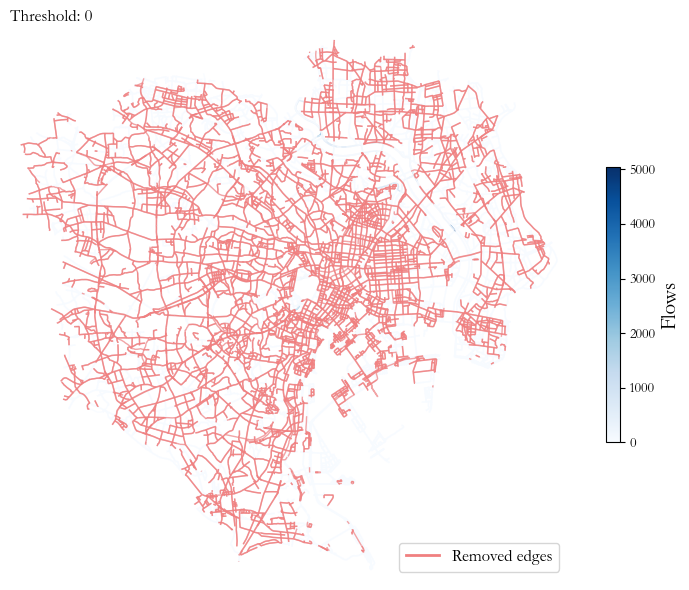

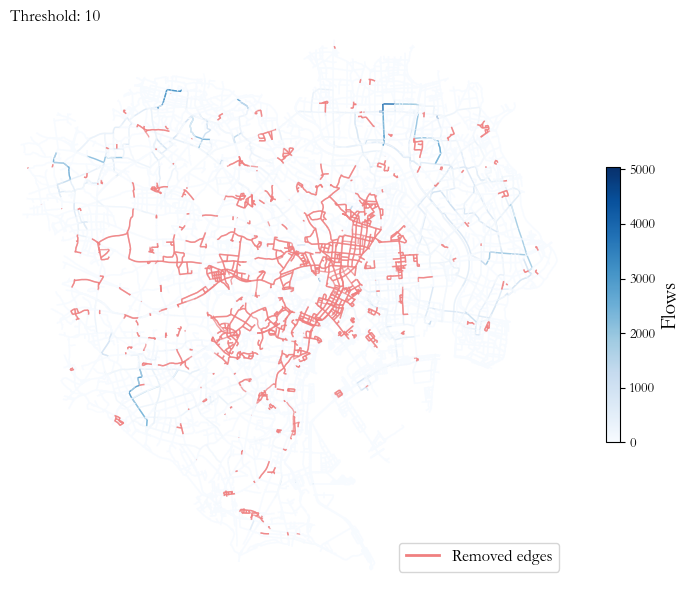

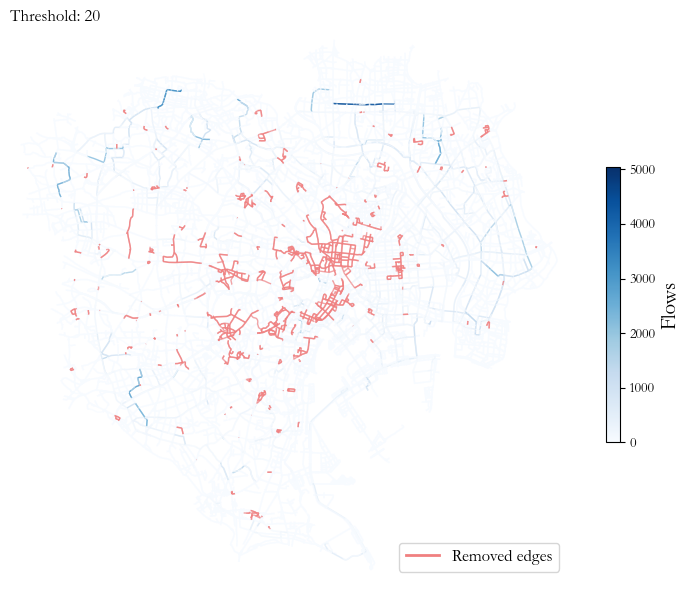

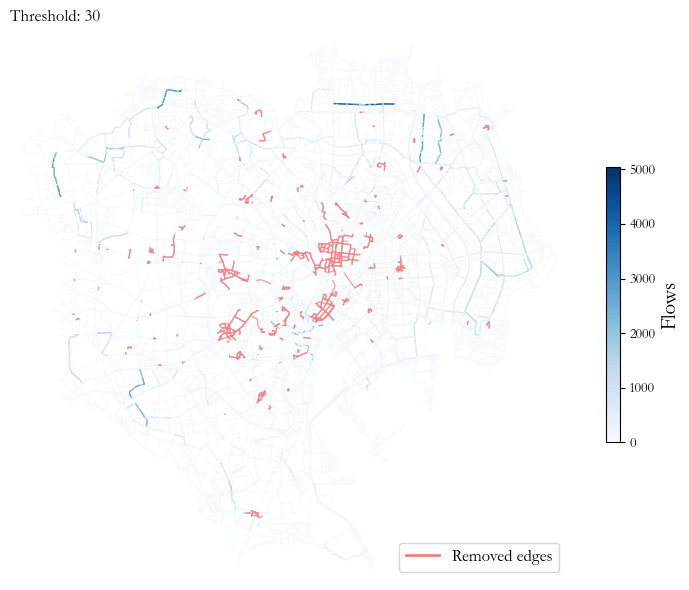

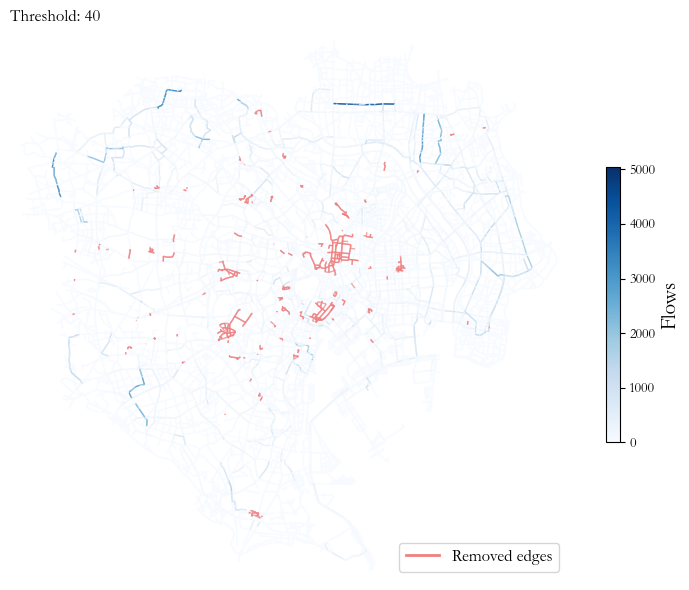

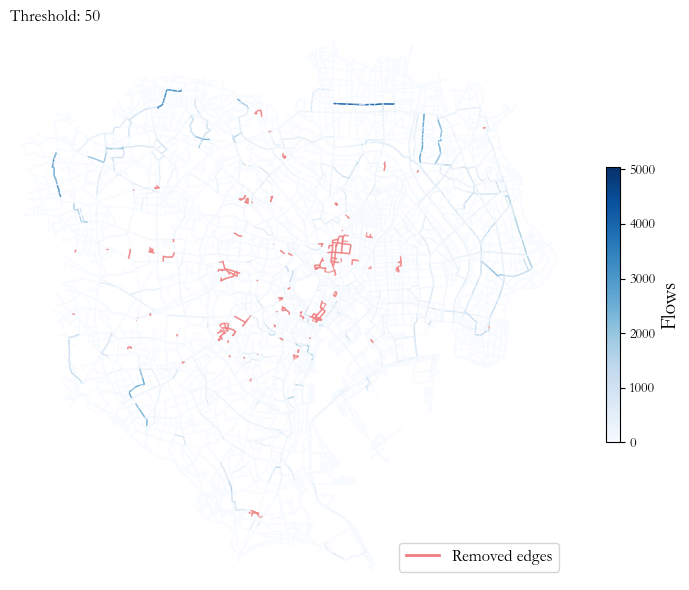

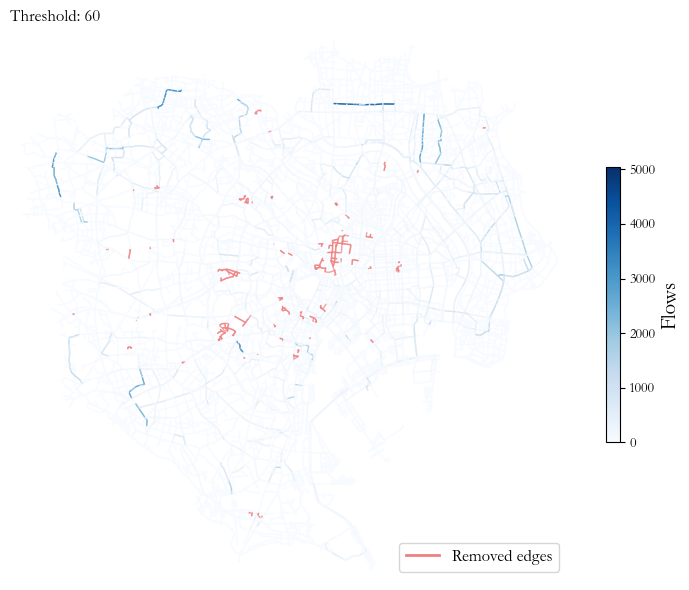

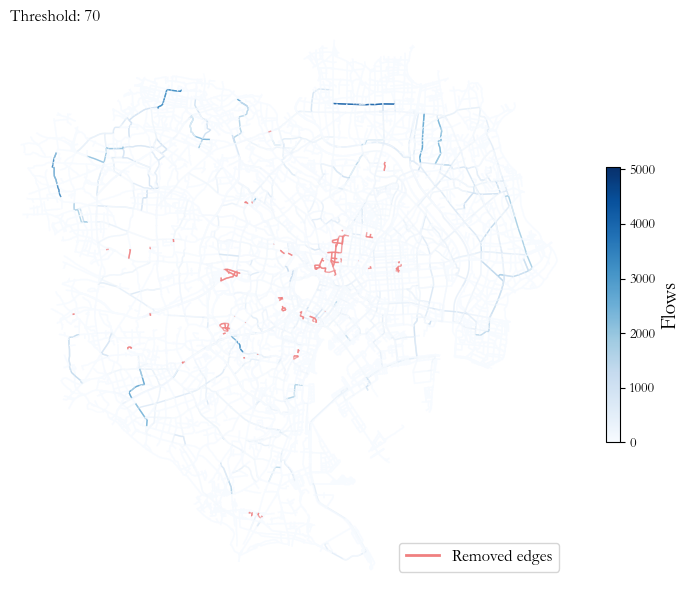

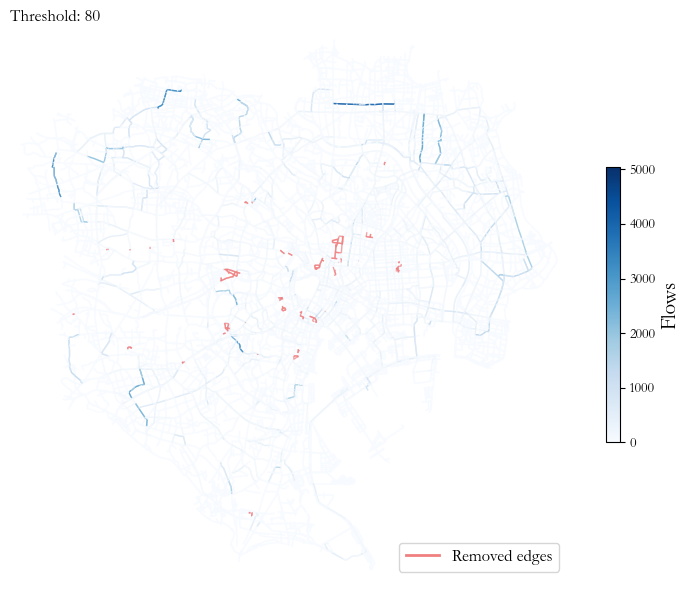

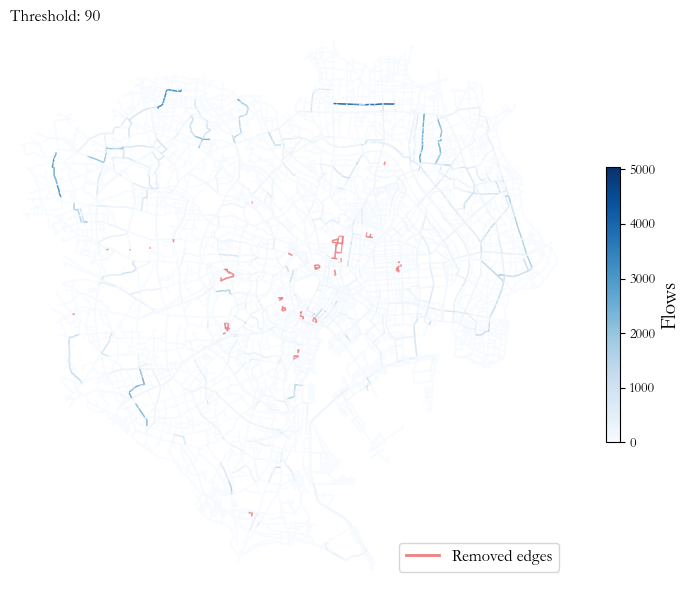

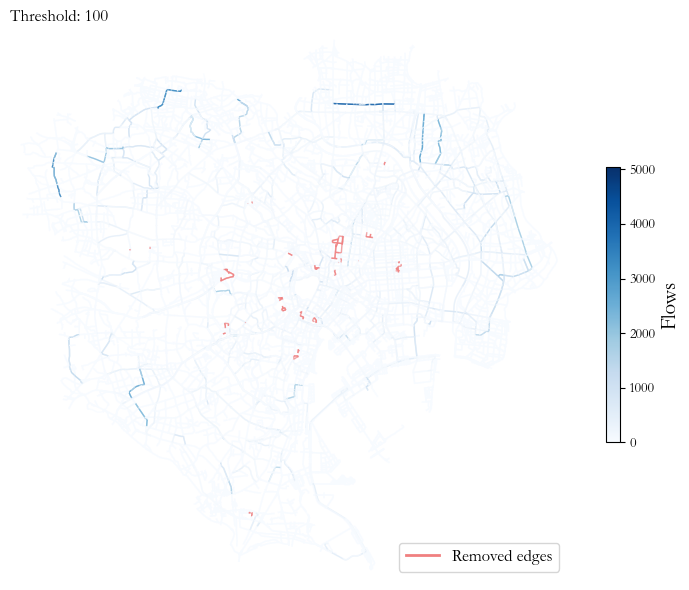

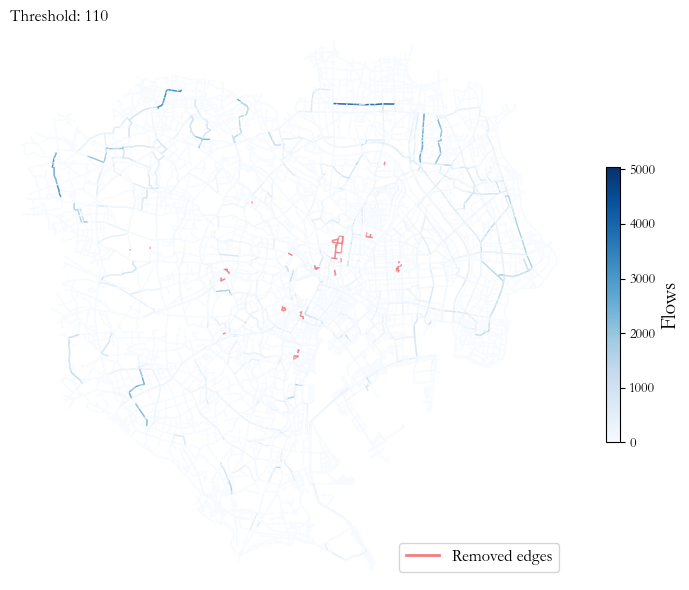

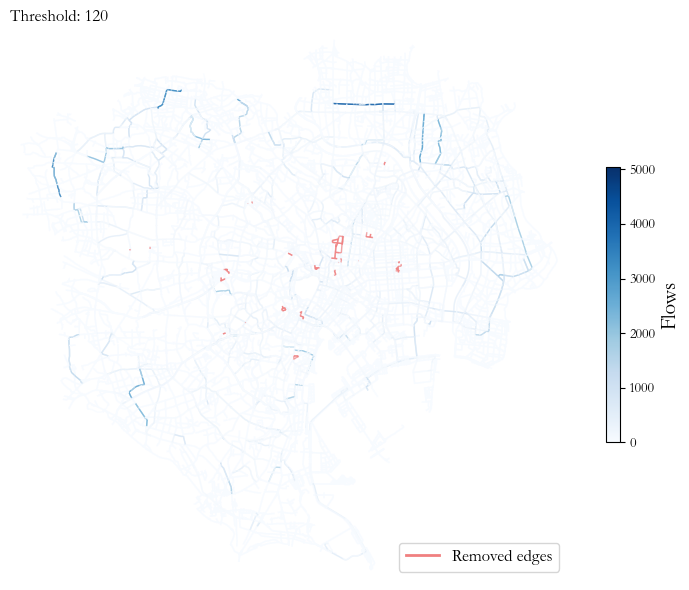

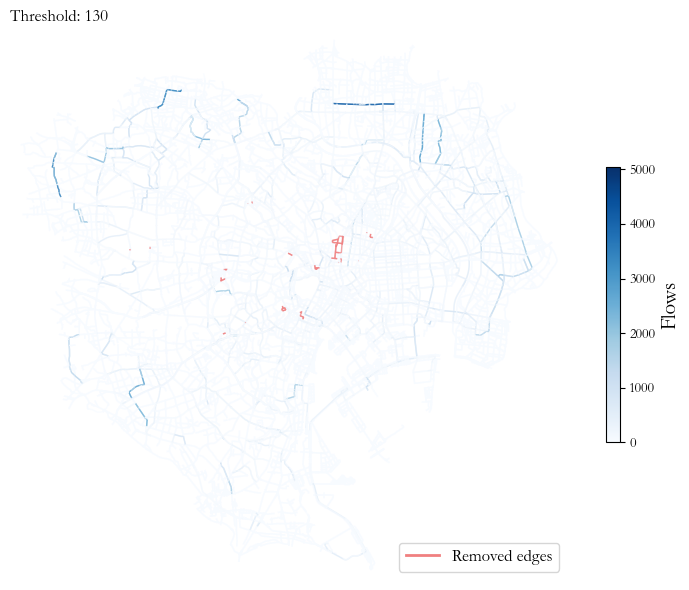

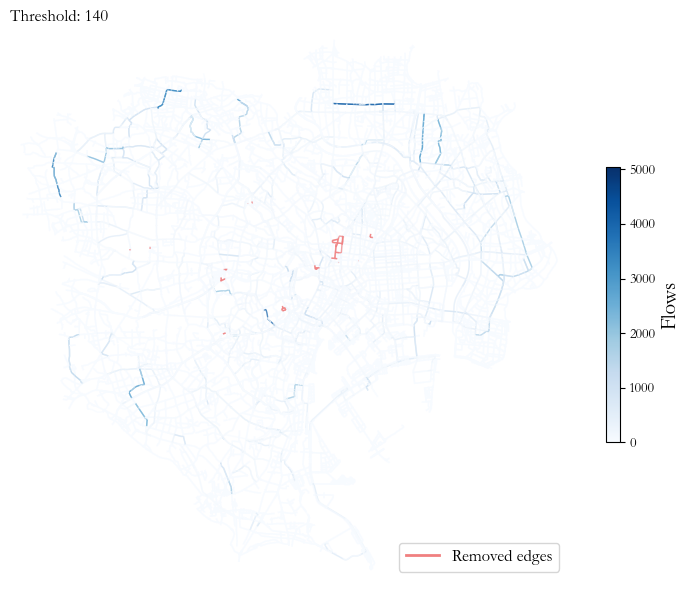

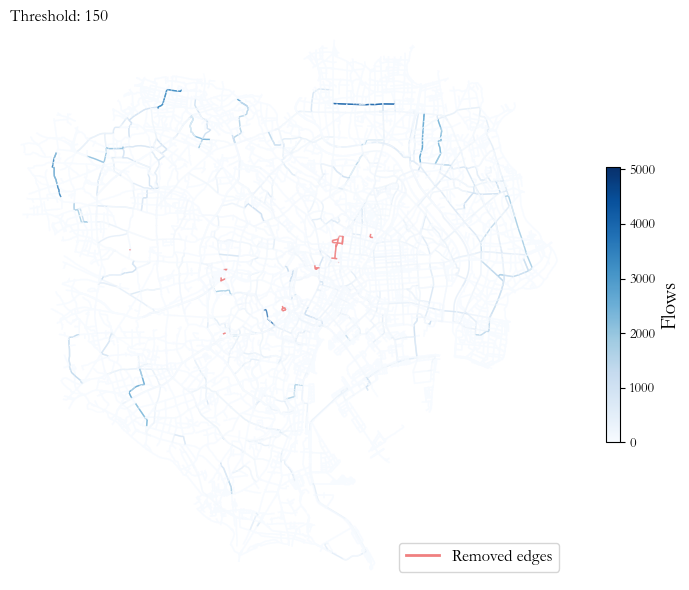

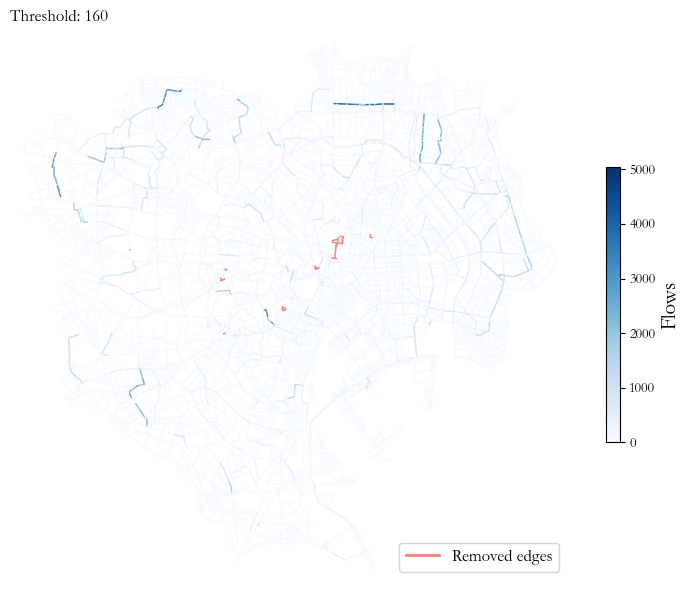

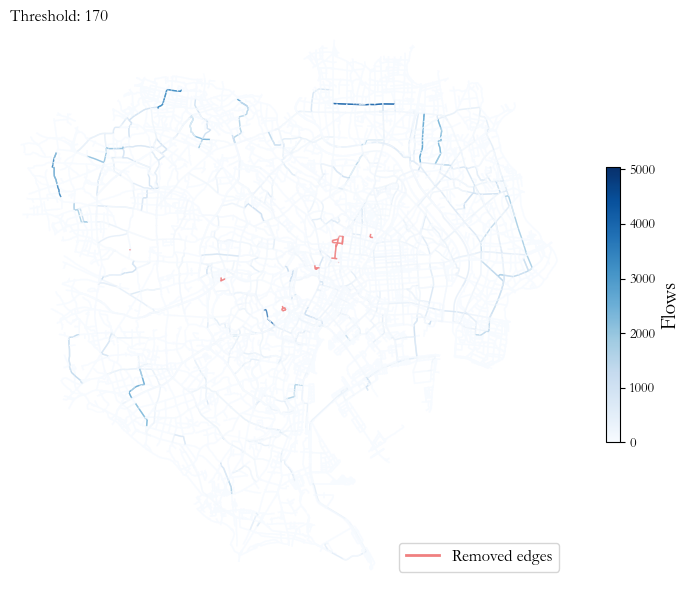

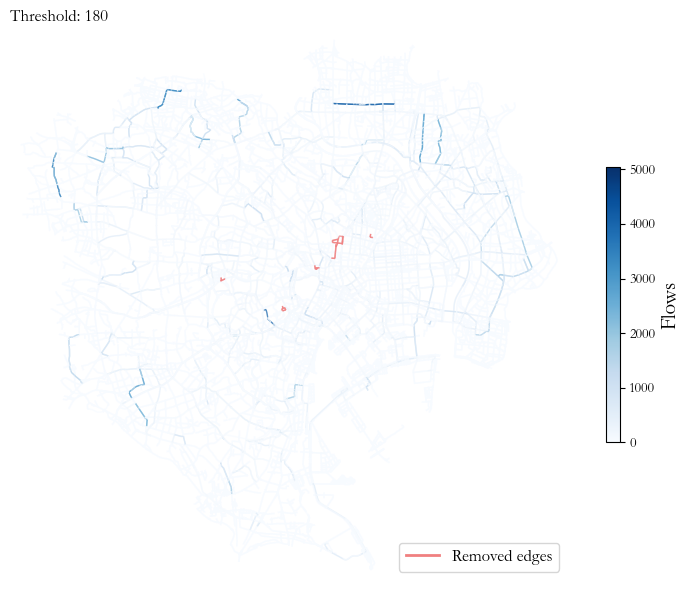

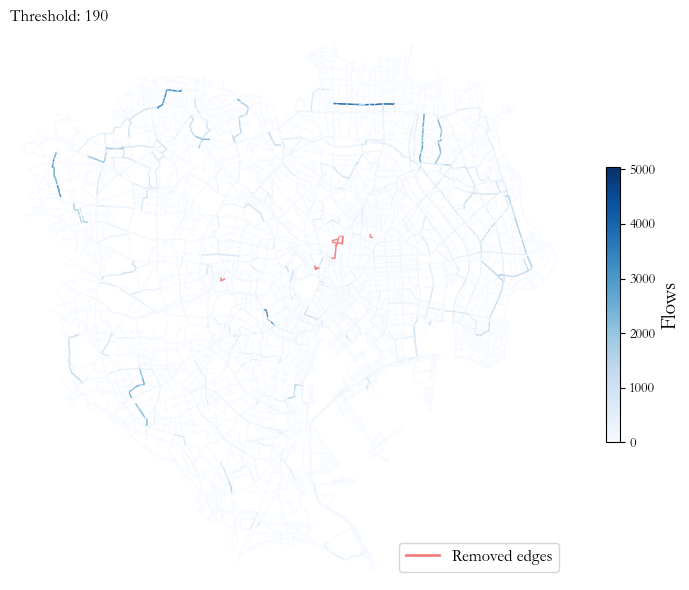

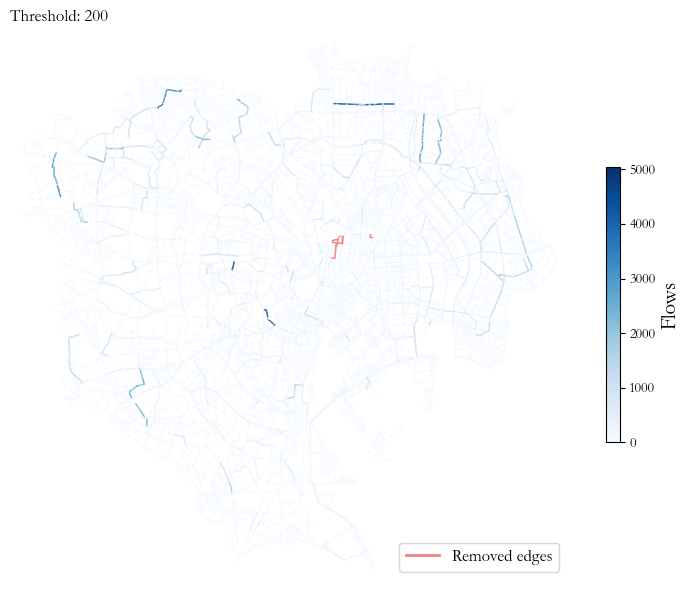

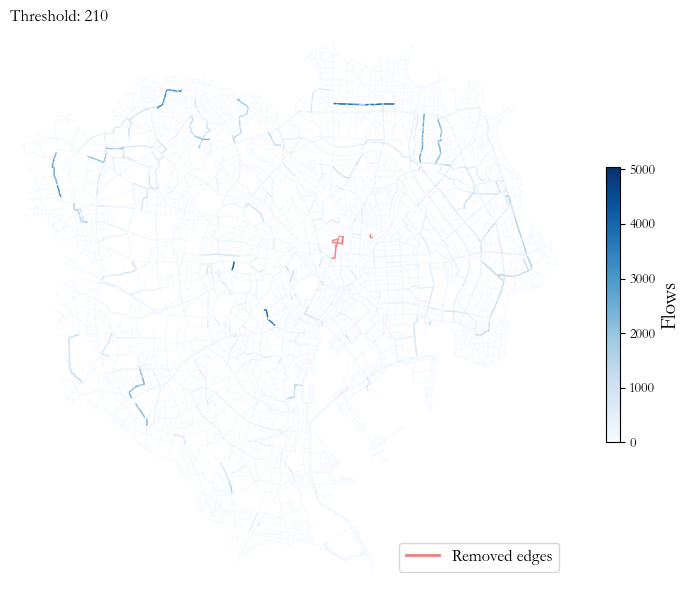

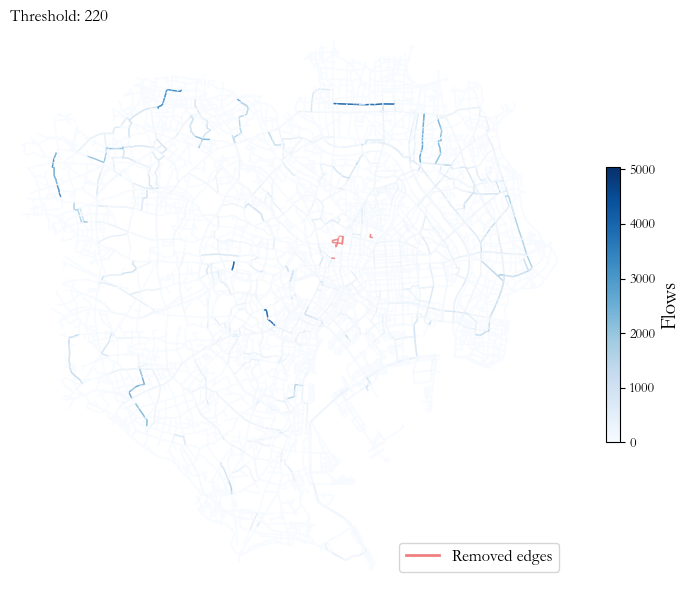

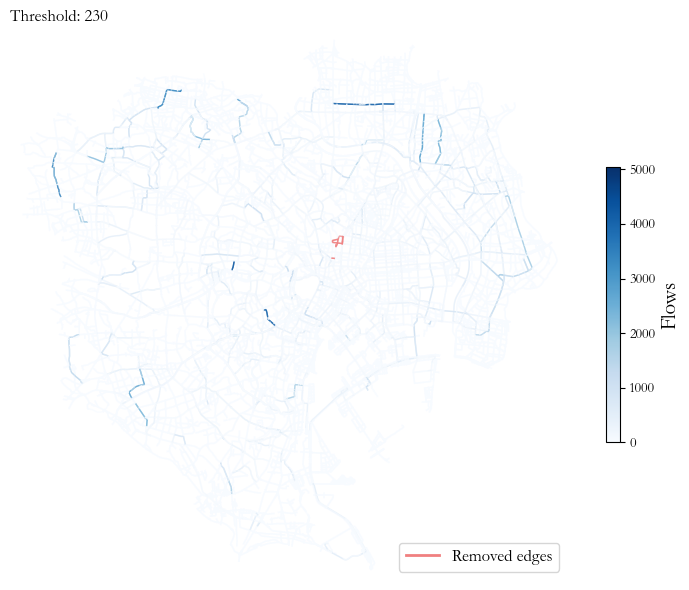

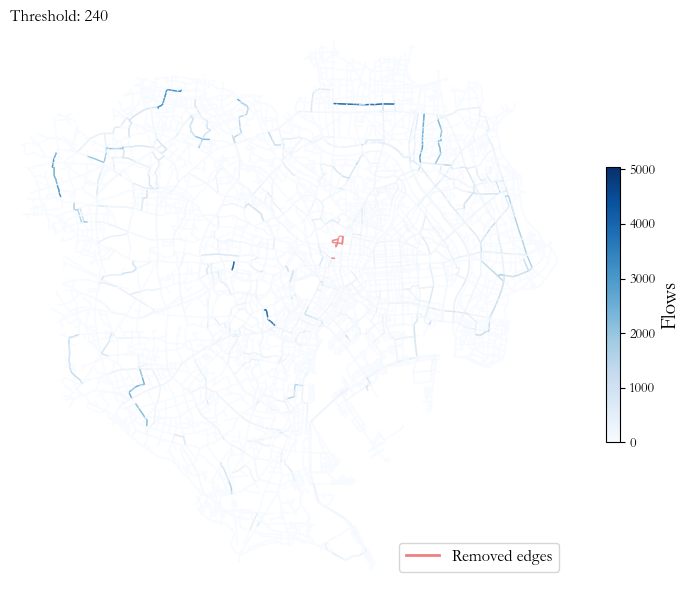

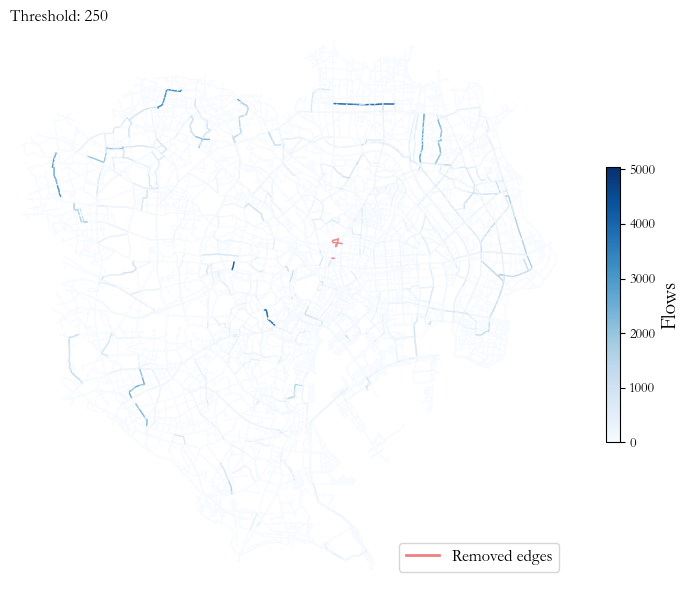

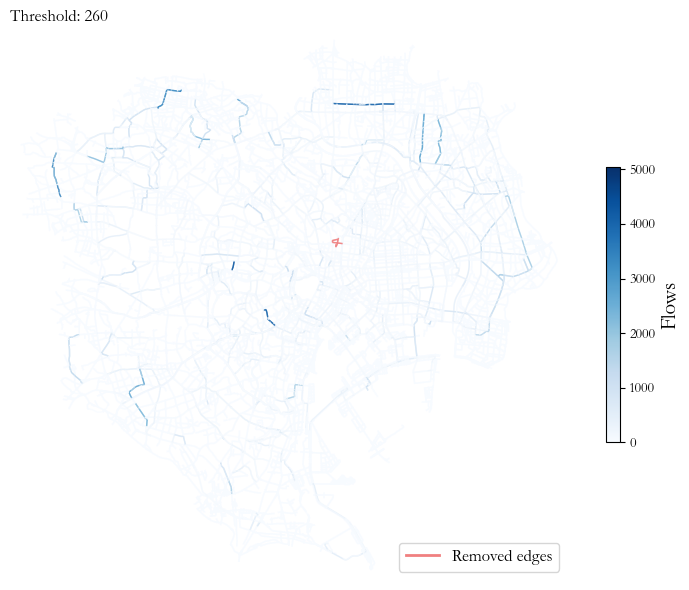

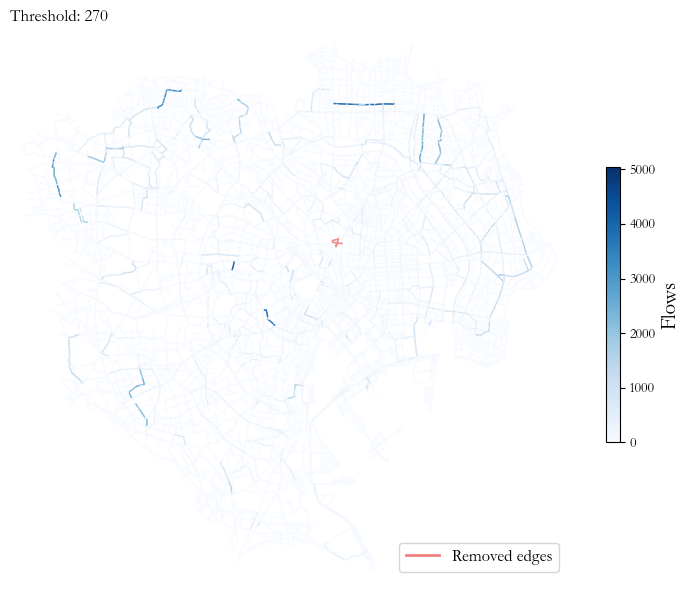

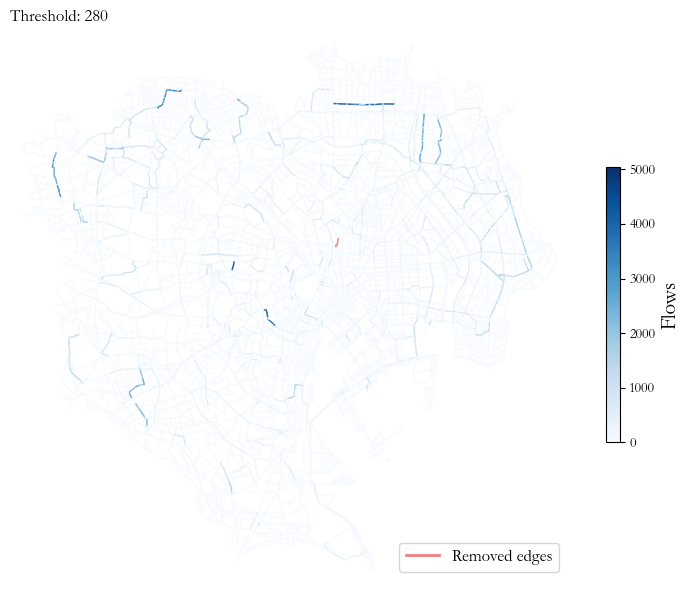

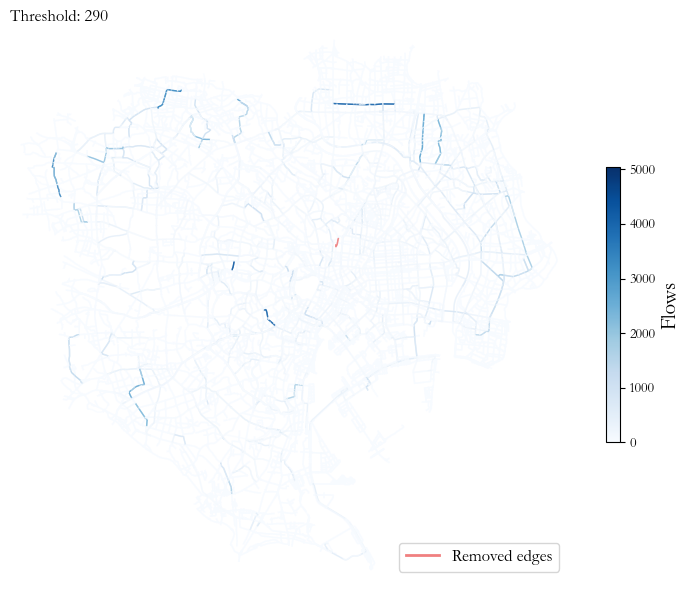

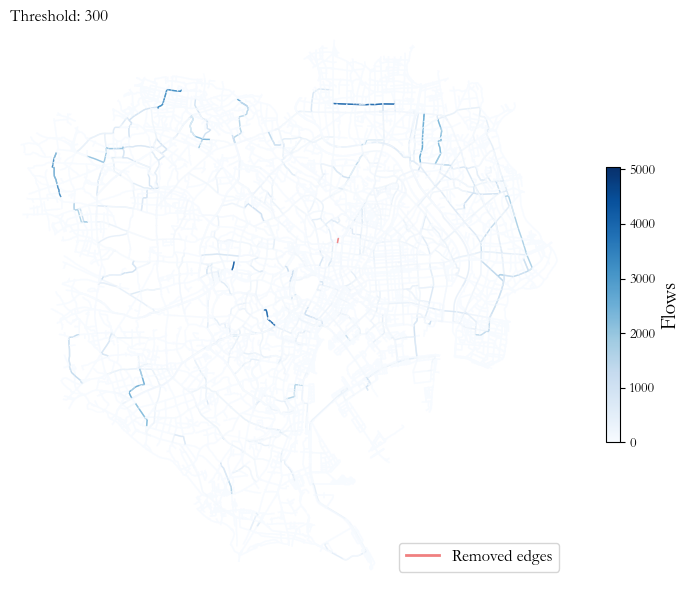

In [79]:
# set threshold
for threshold in range(0, 305, 10):

    # create subgraph
    subgraph_temp = tokyo_drive_network.subgraph([n for n, d in tokyo_drive_network.nodes(data = True) if (d['poi_h3'] > threshold)]).copy()
    remove_edges = []
    for u,v,k,d in subgraph_temp.edges(data = True, keys = True):
        if d['highway'] == 'motorway':
            remove_edges.append((u,v,k))
    subgraph_temp.remove_edges_from(remove_edges)

    # Manually normalize the attribute values
    edge_flows = ox.convert.graph_to_gdfs(tokyo_drive_network, nodes=False)[f'flows_{threshold}']
    normalized_flows = edge_flows / max_flow

    # Get colors using the normalized values
    cmap = plt.get_cmap('Blues')
    colors_poi = [cmap(norm) if norm <= 1 else cmap(1.0) for norm in normalized_flows]

    fig, ax = plt.subplots(1, 1, figsize = (8, 6))

    # draw the drive network 
    ox.plot_graph(
        tokyo_drive_network,
        edge_color = colors_poi,
        node_size = 0,
        edge_alpha = 0.7,
        bgcolor = 'white',
        ax = ax,
        show = False
    )

    # Add colorbar for the first plot
    sm = cm.ScalarMappable(cmap = 'Blues', norm = mcolors.Normalize(vmin = 0, vmax = max_flow))
    cbar = fig.colorbar(sm, ax = ax, aspect = 20, shrink = 0.5, fraction = 0.1)
    cbar.set_label('Flows', fontsize = 15)

    # Capture the bounding box of the first graph
    bbox = ax.get_xlim(), ax.get_ylim()

    # draw the removed edges
    ox.plot_graph(
        subgraph_temp,
        edge_color = 'lightcoral',
        edge_alpha = 0.7,
        node_size = 0,
        ax = ax,
        bgcolor = 'None',
        show = False
    )

    # Set the captured bounding box to the second plot
    ax.set_xlim(bbox[0])
    ax.set_ylim(bbox[1])

    # Add a legend to the second plot
    legend_handles = [
        Line2D([0], [0], color='lightcoral', lw=2, label='Removed edges')
    ]
    ax.legend(handles=legend_handles, loc='lower right', fontsize = 12)

    plt.title(f'Threshold: {threshold}', loc = 'left', fontsize = 12)

    plt.tight_layout()
    plt.savefig(f'documents/img/flows_{threshold}.png', bbox_inches = 'tight')
    plt.close()

## Plot the difference between the original and each scenario.

### Get the Scenarios

In [9]:
scenarios_all = [f'removed_{key}' for key in removed_nodes] + [f'removed_{key}_nodes' for key in removed_nodes] + list(range(0,305,10))

In [11]:
# add difference
for s in scenarios_all:
    for u,v,k,d in tokyo_drive_network.edges(data = True, keys = True):
        d[f'flows_{s}_difference'] = d[f'flows_{s}'] - d['flows_orig']

In [18]:
# get the maximum difference
max_difference = max([v for n in tokyo_drive_network.edges(data = True) for k,v in n[2].items() if 'difference' in k])
min_difference = min([v for n in tokyo_drive_network.edges(data = True) for k,v in n[2].items() if 'difference' in k])

# get the larger absolute value of the two
range_diff = max([abs(max_difference), abs(min_difference)])

In [17]:
range_diff

5017.273033932189

In [14]:
print(max_difference, min_difference)

5017.273033932189 -4297.52960083243


In [15]:
print(max_flow)

5041.842741839613


### Plot

In [22]:
# iterate over scenarios
for scenario in removed_nodes:

    # create subgraph
    subgraph_temp = tokyo_drive_network.subgraph(removed_nodes[scenario]).copy()
    remove_edges = []
    for u,v,k,d in subgraph_temp.edges(data = True, keys = True):
        if d['highway'] == 'motorway':
            remove_edges.append((u,v,k))
    subgraph_temp.remove_edges_from(remove_edges)

    # Manually normalize the attribute values
    flows_diff = ox.convert.graph_to_gdfs(tokyo_drive_network, nodes=False)[f'flows_removed_{scenario}_difference']
    normalized_diff = flows_diff / range_diff

    # Get colors using the normalized values
    cmap = plt.get_cmap('BrBG')
    colors_diff = [cmap((norm) + 1 / 2) for norm in normalized_diff]

    fig, ax = plt.subplots(1, 1, figsize = (8, 6))

    # draw the drive network 
    ox.plot_graph(
        tokyo_drive_network,
        edge_color = colors_diff,
        node_size = 0,
        edge_alpha = 0.7,
        bgcolor = 'white',
        ax = ax,
        show = False
    )

    # Add colorbar for the first plot
    sm = cm.ScalarMappable(cmap = 'BrBG', norm = mcolors.Normalize(vmin = -range_diff, vmax = range_diff))
    cbar = fig.colorbar(sm, ax = ax, aspect = 20, shrink = 0.5, fraction = 0.1)
    cbar.set_label('Change in Flows', fontsize = 15)

    # Capture the bounding box of the first graph
    bbox = ax.get_xlim(), ax.get_ylim()

    # draw the removed edges
    ox.plot_graph(
        subgraph_temp,
        edge_color = 'lightcoral',
        edge_alpha = 0.7,
        node_size = 0,
        ax = ax,
        bgcolor = 'None',
        show = False
    )

    # Set the captured bounding box to the second plot
    ax.set_xlim(bbox[0])
    ax.set_ylim(bbox[1])

    # Add a legend to the second plot
    legend_handles = [
        Line2D([0], [0], color='lightcoral', lw=2, label='Removed edges')
    ]
    ax.legend(handles=legend_handles, loc='lower right', fontsize = 12)

    plt.title(f'Scenario: Removed {scenario} (Edge Removal)', loc = 'left', fontsize = 12)

    plt.tight_layout()
    plt.savefig(f'documents/img/diff_abs_flows_{scenario}.png', bbox_inches = 'tight')
    plt.close()

In [25]:
# iterate over scenarios
for scenario in removed_nodes:

    # create subgraph
    subgraph_edges = [(u,v,k) for u,v,k in tokyo_drive_network.edges(keys = True) if (u in removed_nodes[scenario]) or (v in removed_nodes[scenario])]

    subgraph_temp = tokyo_drive_network.edge_subgraph(subgraph_edges).copy()
    remove_edges = []
    for u,v,k,d in subgraph_temp.edges(data = True, keys = True):
        if d['highway'] == 'motorway':
            remove_edges.append((u,v,k))
    subgraph_temp.remove_edges_from(remove_edges)

    # Manually normalize the attribute values
    flows_diff = ox.convert.graph_to_gdfs(tokyo_drive_network, nodes=False)[f'flows_removed_{scenario}_nodes_difference']
    normalized_diff = flows_diff / range_diff

    # Get colors using the normalized values
    cmap = plt.get_cmap('BrBG')
    colors_diff = [cmap((norm) + 1 / 2) for norm in normalized_diff]

    fig, ax = plt.subplots(1, 1, figsize = (8, 6))

    # draw the drive network 
    ox.plot_graph(
        tokyo_drive_network,
        edge_color = colors_diff,
        node_size = 0,
        edge_alpha = 0.7,
        bgcolor = 'white',
        ax = ax,
        show = False
    )

    # Add colorbar for the first plot
    sm = cm.ScalarMappable(cmap = 'BrBG', norm = mcolors.Normalize(vmin = -range_diff, vmax = range_diff))
    cbar = fig.colorbar(sm, ax = ax, aspect = 20, shrink = 0.5, fraction = 0.1)
    cbar.set_label('Change in Flows', fontsize = 15)

    # Capture the bounding box of the first graph
    bbox = ax.get_xlim(), ax.get_ylim()

    # draw the removed edges
    ox.plot_graph(
        subgraph_temp,
        edge_color = 'lightcoral',
        edge_alpha = 0.7,
        node_size = 0,
        ax = ax,
        bgcolor = 'None',
        show = False
    )

    # Set the captured bounding box to the second plot
    ax.set_xlim(bbox[0])
    ax.set_ylim(bbox[1])

    # Add a legend to the second plot
    legend_handles = [
        Line2D([0], [0], color='lightcoral', lw=2, label='Removed edges')
    ]
    ax.legend(handles=legend_handles, loc='lower right', fontsize = 12)

    plt.title(f'Scenario: Removed {scenario} (Node Removal)', loc = 'left', fontsize = 12)

    plt.tight_layout()
    plt.savefig(f'documents/img/diff_abs_flows_{scenario}_nodes.png', bbox_inches = 'tight')
    plt.close()

In [26]:
# set threshold
for threshold in range(0, 305, 10):

    # create subgraph
    subgraph_temp = tokyo_drive_network.subgraph([n for n, d in tokyo_drive_network.nodes(data = True) if (d['poi_h3'] > threshold)]).copy()
    remove_edges = []
    for u,v,k,d in subgraph_temp.edges(data = True, keys = True):
        if d['highway'] == 'motorway':
            remove_edges.append((u,v,k))
    subgraph_temp.remove_edges_from(remove_edges)

    # Manually normalize the attribute values
    flows_diff = ox.convert.graph_to_gdfs(tokyo_drive_network, nodes=False)[f'flows_{threshold}_difference']
    normalized_diff = flows_diff / range_diff

    # Get colors using the normalized values
    cmap = plt.get_cmap('BrBG')
    colors_diff = [cmap((norm) + 1 / 2) for norm in normalized_diff]

    fig, ax = plt.subplots(1, 1, figsize = (8, 6))

    # draw the drive network 
    ox.plot_graph(
        tokyo_drive_network,
        edge_color = colors_diff,
        node_size = 0,
        edge_alpha = 0.7,
        bgcolor = 'white',
        ax = ax,
        show = False
    )

    # Add colorbar for the first plot
    sm = cm.ScalarMappable(cmap = 'BrBG', norm = mcolors.Normalize(vmin = -range_diff, vmax = range_diff))
    cbar = fig.colorbar(sm, ax = ax, aspect = 20, shrink = 0.5, fraction = 0.1)
    cbar.set_label('Change in Flows', fontsize = 15)

    # Capture the bounding box of the first graph
    bbox = ax.get_xlim(), ax.get_ylim()

    # draw the removed edges
    ox.plot_graph(
        subgraph_temp,
        edge_color = 'lightcoral',
        edge_alpha = 0.7,
        node_size = 0,
        ax = ax,
        bgcolor = 'None',
        show = False
    )

    # Set the captured bounding box to the second plot
    ax.set_xlim(bbox[0])
    ax.set_ylim(bbox[1])

    # Add a legend to the second plot
    legend_handles = [
        Line2D([0], [0], color='lightcoral', lw=2, label='Removed edges')
    ]
    ax.legend(handles=legend_handles, loc='lower right', fontsize = 12)

    plt.title(f'Threshold: {threshold}', loc = 'left', fontsize = 12)

    plt.tight_layout()
    plt.savefig(f'documents/img/diff_abs_flows_{threshold}.png', bbox_inches = 'tight')
    plt.close()

### Go for the relative ones for the real scenarios

Considering the difference using the preferred measures may lead to better visualisations

In [31]:
# set colorbar range
colorbar_range = 1000

# iterate over scenarios
for scenario in removed_nodes:

    # create subgraph
    subgraph_temp = tokyo_drive_network.subgraph(removed_nodes[scenario]).copy()
    remove_edges = []
    for u,v,k,d in subgraph_temp.edges(data = True, keys = True):
        if d['highway'] == 'motorway':
            remove_edges.append((u,v,k))
    subgraph_temp.remove_edges_from(remove_edges)

    # Manually normalize the attribute values
    flows_diff = ox.convert.graph_to_gdfs(tokyo_drive_network, nodes=False)[f'flows_removed_{scenario}_difference']
    normalized_diff = flows_diff / colorbar_range

    # Get colors using the normalized values
    cmap = plt.get_cmap('BrBG')
    colors_diff = [cmap((norm) + 1 / 2) if abs(norm) <= 1 else cmap((norm / abs(norm))) for norm in normalized_diff]

    fig, ax = plt.subplots(1, 1, figsize = (8, 6))

    # draw the drive network 
    ox.plot_graph(
        tokyo_drive_network,
        edge_color = colors_diff,
        node_size = 0,
        edge_alpha = 0.7,
        bgcolor = 'white',
        ax = ax,
        show = False
    )

    # Add colorbar for the first plot
    sm = cm.ScalarMappable(cmap = 'BrBG', norm = mcolors.Normalize(vmin = -colorbar_range, vmax = colorbar_range))
    cbar = fig.colorbar(sm, ax = ax, aspect = 20, shrink = 0.5, fraction = 0.1, extend = 'both')
    cbar.set_label('Change in Flows', fontsize = 15)

    # Capture the bounding box of the first graph
    bbox = ax.get_xlim(), ax.get_ylim()

    # draw the removed edges
    ox.plot_graph(
        subgraph_temp,
        edge_color = 'lightcoral',
        edge_alpha = 0.7,
        node_size = 0,
        ax = ax,
        bgcolor = 'None',
        show = False
    )

    # Set the captured bounding box to the second plot
    ax.set_xlim(bbox[0])
    ax.set_ylim(bbox[1])

    # Add a legend to the second plot
    legend_handles = [
        Line2D([0], [0], color='lightcoral', lw=2, label='Removed edges')
    ]
    ax.legend(handles=legend_handles, loc='lower right', fontsize = 12)

    plt.title(f'Scenario: Removed {scenario} (Edge Removal)', loc = 'left', fontsize = 12)

    plt.tight_layout()
    plt.savefig(f'documents/img/diff_flows_{scenario}.png', bbox_inches = 'tight')
    plt.close()

In [32]:
# set colorbar range
colorbar_range = 1000

# iterate over scenarios
for scenario in removed_nodes:

    # create subgraph
    subgraph_edges = [(u,v,k) for u,v,k in tokyo_drive_network.edges(keys = True) if (u in removed_nodes[scenario]) or (v in removed_nodes[scenario])]

    subgraph_temp = tokyo_drive_network.edge_subgraph(subgraph_edges).copy()
    remove_edges = []
    for u,v,k,d in subgraph_temp.edges(data = True, keys = True):
        if d['highway'] == 'motorway':
            remove_edges.append((u,v,k))
    subgraph_temp.remove_edges_from(remove_edges)

    # Manually normalize the attribute values
    flows_diff = ox.convert.graph_to_gdfs(tokyo_drive_network, nodes=False)[f'flows_removed_{scenario}_nodes_difference']
    normalized_diff = flows_diff / colorbar_range

    # Get colors using the normalized values
    cmap = plt.get_cmap('BrBG')
    colors_diff = [cmap((norm) + 1 / 2) if abs(norm) <= 1 else cmap((norm / abs(norm))) for norm in normalized_diff]

    fig, ax = plt.subplots(1, 1, figsize = (8, 6))

    # draw the drive network 
    ox.plot_graph(
        tokyo_drive_network,
        edge_color = colors_diff,
        node_size = 0,
        edge_alpha = 0.7,
        bgcolor = 'white',
        ax = ax,
        show = False
    )

    # Add colorbar for the first plot
    sm = cm.ScalarMappable(cmap = 'BrBG', norm = mcolors.Normalize(vmin = -colorbar_range, vmax = colorbar_range))
    cbar = fig.colorbar(sm, ax = ax, aspect = 20, shrink = 0.5, fraction = 0.1, extend = 'both')
    cbar.set_label('Change in Flows', fontsize = 15)

    # Capture the bounding box of the first graph
    bbox = ax.get_xlim(), ax.get_ylim()

    # draw the removed edges
    ox.plot_graph(
        subgraph_temp,
        edge_color = 'lightcoral',
        edge_alpha = 0.7,
        node_size = 0,
        ax = ax,
        bgcolor = 'None',
        show = False
    )

    # Set the captured bounding box to the second plot
    ax.set_xlim(bbox[0])
    ax.set_ylim(bbox[1])

    # Add a legend to the second plot
    legend_handles = [
        Line2D([0], [0], color='lightcoral', lw=2, label='Removed edges')
    ]
    ax.legend(handles=legend_handles, loc='lower right', fontsize = 12)

    plt.title(f'Scenario: Removed {scenario} (Node Removal)', loc = 'left', fontsize = 12)

    plt.tight_layout()
    plt.savefig(f'documents/img/diff_flows_{scenario}_nodes.png', bbox_inches = 'tight')
    plt.close()

In [33]:
# set colorbar range
colorbar_range = 1000

# set threshold
for threshold in range(0, 305, 10):

    # create subgraph
    subgraph_temp = tokyo_drive_network.subgraph([n for n, d in tokyo_drive_network.nodes(data = True) if (d['poi_h3'] > threshold)]).copy()
    remove_edges = []
    for u,v,k,d in subgraph_temp.edges(data = True, keys = True):
        if d['highway'] == 'motorway':
            remove_edges.append((u,v,k))
    subgraph_temp.remove_edges_from(remove_edges)

    # Manually normalize the attribute values
    flows_diff = ox.convert.graph_to_gdfs(tokyo_drive_network, nodes=False)[f'flows_{threshold}_difference']
    normalized_diff = flows_diff / colorbar_range

    # Get colors using the normalized values
    cmap = plt.get_cmap('BrBG')
    colors_diff = [cmap((norm) + 1 / 2) if abs(norm) <= 1 else cmap((norm / abs(norm))) for norm in normalized_diff]

    fig, ax = plt.subplots(1, 1, figsize = (8, 6))

    # draw the drive network 
    ox.plot_graph(
        tokyo_drive_network,
        edge_color = colors_diff,
        node_size = 0,
        edge_alpha = 0.7,
        bgcolor = 'white',
        ax = ax,
        show = False
    )

    # Add colorbar for the first plot
    sm = cm.ScalarMappable(cmap = 'BrBG', norm = mcolors.Normalize(vmin = -colorbar_range, vmax = colorbar_range))
    cbar = fig.colorbar(sm, ax = ax, aspect = 20, shrink = 0.5, fraction = 0.1, extend = 'both')
    cbar.set_label('Change in Flows', fontsize = 15)

    # Capture the bounding box of the first graph
    bbox = ax.get_xlim(), ax.get_ylim()

    # draw the removed edges
    ox.plot_graph(
        subgraph_temp,
        edge_color = 'lightcoral',
        edge_alpha = 0.7,
        node_size = 0,
        ax = ax,
        bgcolor = 'None',
        show = False
    )

    # Set the captured bounding box to the second plot
    ax.set_xlim(bbox[0])
    ax.set_ylim(bbox[1])

    # Add a legend to the second plot
    legend_handles = [
        Line2D([0], [0], color='lightcoral', lw=2, label='Removed edges')
    ]
    ax.legend(handles=legend_handles, loc='lower right', fontsize = 12)

    plt.title(f'Threshold: {threshold}', loc = 'left', fontsize = 12)

    plt.tight_layout()
    plt.savefig(f'documents/img/diff_flows_{threshold}.png', bbox_inches = 'tight')
    plt.close()